In [4]:
!pip install scikit-learn
!pip install setuptools 
!pip install emlearn
!pip install numpy
!pip install matplotlib



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# RandomForest model optimization on real dataset (Cross, Shots, and Noise included)
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# --- Paths ---
base_dir = r"c:/TML_Particle_EH5/Project/Project/ModelWork/"
data_path = os.path.join(base_dir, "features_dataset.csv")
best_model_path = os.path.join(base_dir, "rf_best_model.pkl")
report_path = os.path.join(base_dir, "rf_optimization_report.txt")
matrix_path = os.path.join(base_dir, "rf_optimization_confusion.png")

# --- Load dataset ---
df = pd.read_csv(data_path)
print(f"Loaded dataset with {len(df)} samples.")
print("Class distribution:")
print(df["label"].value_counts())

X = df.drop(columns=["filename", "label"])
y = df["label"]

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"\nTraining samples: {len(X_train)}, Test samples: {len(X_test)}")

# --- Parameter grid for optimization ---
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# --- Grid search ---
grid = GridSearchCV(
    estimator=RandomForestClassifier(
        class_weight="balanced",  # Brug alle data, men vægt automatisk ubalancerede klasser
        random_state=42
    ),
    param_grid=param_grid,
    scoring="f1_weighted",
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)
print("\nBest parameters found:\n", grid.best_params_)
print(f"Cross-validated F1 score: {grid.best_score_:.4f}")

best_model = grid.best_estimator_

# --- Test on unseen test data ---
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
report = classification_report(y_test, y_pred, digits=3)
matrix = confusion_matrix(y_test, y_pred)

print("\n--- Performance on Test Data ---")
print(f"Accuracy: {acc:.3f}")
print(f"Weighted F1-score: {f1:.3f}")
print("\nClassification report:\n", report)
print("Confusion matrix:\n", matrix)

# --- Save outputs ---
joblib.dump(best_model, best_model_path)

with open(report_path, "w") as f:
    f.write("Best parameters:\n")
    f.write(str(grid.best_params_) + "\n\n")
    f.write(f"Cross-validated F1 score: {grid.best_score_:.4f}\n")
    f.write(f"Test Accuracy: {acc:.3f}\n")
    f.write(f"Test F1: {f1:.3f}\n\n")
    f.write(report)

plt.figure(figsize=(6,5))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.title("Confusion Matrix (Cross / Shot / Noise)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(matrix_path)
plt.close()

print(f"\nSaved optimized model and evaluation results in {base_dir}")


Loaded dataset with 296 samples.
Class distribution:
label
pass     77
cross    75
noise    75
shot     69
Name: count, dtype: int64

Training samples: 207, Test samples: 89
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters found:
 {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Cross-validated F1 score: 0.8310

--- Performance on Test Data ---
Accuracy: 0.876
Weighted F1-score: 0.871

Classification report:
               precision    recall  f1-score   support

       cross      0.846     0.957     0.898        23
       noise      0.840     0.955     0.894        22
        pass      1.000     0.957     0.978        23
        shot      0.812     0.619     0.703        21

    accuracy                          0.876        89
   macro avg      0.875     0.872     0.868        89
weighted avg      0.876     0.876     0.871        89

Confusion matrix:
 [[22  0  0  1]
 [ 0 21  0  1]
 [ 0  0 22  1]
 [ 4  4  0 13]]

Sa

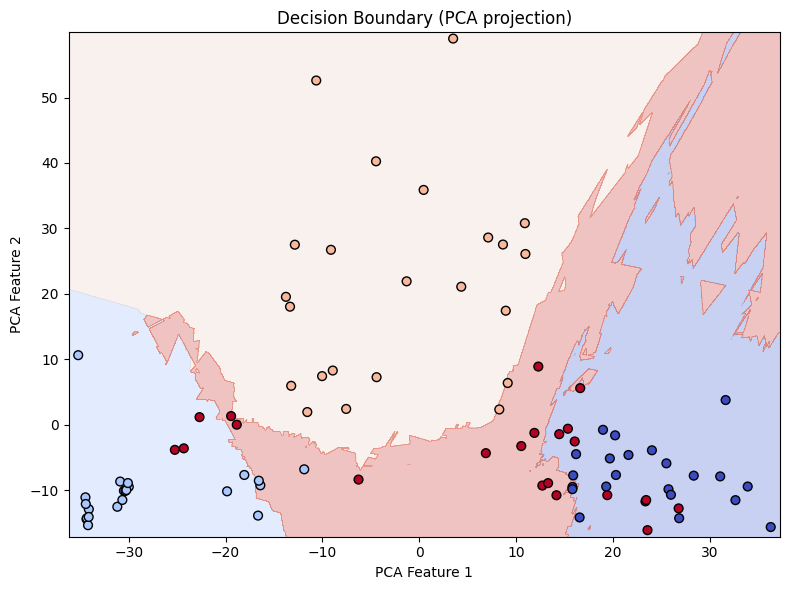

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import warnings

def plot_decision_boundary_pca(model, X, y, title="Decision Boundary (PCA projection)"):
    # Reducer til 2D med PCA
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    # Opret grid
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))

    # Forudsig klasser på gridpunkter
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))

    # Konverter strenglabels til numeriske værdier
    le = LabelEncoder()
    le.fit(y)
    Z_num = le.transform(Z)

    # Form Z til samme form som meshgrid
    Z_num = Z_num.reshape(xx.shape)

    # Plot beslutningsgrænse
    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z_num, alpha=0.3, cmap=plt.cm.coolwarm)

    # Plot datapunkter
    y_num = le.transform(y)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_num, cmap=plt.cm.coolwarm, edgecolors='k', s=40)

    plt.xlabel("PCA Feature 1")
    plt.ylabel("PCA Feature 2")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_decision_boundary_pca(best_model, X_test, y_test)

## Optimize your model
Tune the depth and number of trees, etc....

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import pandas as pd

df = pd.read_csv("c:/TML_Particle_EH5/Project/Project/ModelWork/features_dataset.csv")

X = df.drop(columns=["filename", "label"])
y = df["label"]

# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)


# ----- Hyperparameter grid -----
depths  = [1, 2, 3, 4, 5, 7, 9, 11]
trees   = [1, 2, 3, 5, 7, 10, 15, 20, 30, 50, 100]

# Store as [len(trees), len(depths)] so rows=trees, cols=depths
train_scores = np.zeros((len(trees), len(depths)))
test_scores  = np.zeros((len(trees), len(depths)))

for ti, n_tree in enumerate(trees):
    for di, depth in enumerate(depths):
        clf = RandomForestClassifier(
            n_estimators=n_tree,
            max_depth=depth,
            max_features=2,      # we have 2 features (x,y); keeps capacity comparable
            random_state=1,
        )
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        y_test_pred  = clf.predict(X_test)
        train_scores[ti, di] = f1_score(y_train, y_train_pred)
        test_scores[ti, di]  = f1_score(y_test,  y_test_pred)

# ----- Plot heatmaps (contourf) -----
D, T = np.meshgrid(depths, trees)  # X=depths (columns), Y=trees (rows)

fig, axs = plt.subplots(1, 2, figsize=(11, 4), sharex=True, sharey=True)
levels = np.linspace(0.5, 1.0, 26)  # adjust if needed

h1 = axs[0].contourf(D, T, train_scores, levels=levels)
axs[0].set_title("train_score")
axs[0].set_xlabel("depth")
axs[0].set_ylabel("trees")
axs[0].set_yscale("log")

h2 = axs[1].contourf(D, T, test_scores, levels=levels)
axs[1].set_title("test_score")
axs[1].set_xlabel("depth")
axs[1].set_yscale("log")

# Colorbar shared
cbar = fig.colorbar(h2, ax=axs.ravel().tolist(), shrink=0.9)
cbar.set_label("F1 score")

plt.tight_layout()
#plt.show()

# ----- (Optional) highlight best test point and generalization gap -----
best_idx = np.unravel_index(np.argmax(test_scores), test_scores.shape)
best_trees = trees[best_idx[0]]
best_depth = depths[best_idx[1]]
best_f1    = test_scores[best_idx]
print(f"Best test F1 at depth={best_depth}, trees={best_trees}: F1={best_f1:.3f}")

gap = train_scores - test_scores
gap_idx = np.unravel_index(np.argmax(gap), gap.shape)
print(f"Largest overfit (train-test gap) at depth={depths[gap_idx[1]]}, "
      f"trees={trees[gap_idx[0]]}: gap={gap[gap_idx]:.3f}")

# Mark on plots
axs[1].plot(best_depth, best_trees, 'ro', markersize=12, label='best test')
axs[1].plot(depths[gap_idx[1]], trees[gap_idx[0]], 'wx', markersize=12, label='largest gap')
axs[1].legend()
plt.show()



ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [5]:
best_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)
best_model.fit(X_train, y_train)
joblib.dump(best_model, "c:/TML_Particle_EH5/Project/Project/ModelWork/rf_best_model.pkl")


NameError: name 'joblib' is not defined